In [4]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
%matplotlib inline  

### Regularized Autoencoders 

code($h$) dimension을 인풋 차원보다 작게 가지는 Undercomplete autoencoders는 데이터의 중요한 특징을 학습할 수 있지만 capacity가 너무 커지면 실패한다는 것을 보았다. 이러한 문제는 인풋 차원과 hidden을 같게 만들거나 더 크게 만드는 overcomplete에서도 나타나는 문제이다. 

이상적으로는 code dimension과 encoder, decoder의 capacity를 잘 선택하면 어떠한 오토인코더 구조도 학습할 수 있다. <strong>Regularized autoencoders</strong>도 이러한 능력을 제공한다. 인코더와 디코더를 얕게 그리고 code의 사이즈를 작게 유지하는 것 대신, regularized autoencoders는 loss function이 모델을 카피 외에도 다른 속성들을 가지도록 격려한다.

이러한 속성들은 <strong>sparsity of the representation, smallness of the derivative of the representation, and robustness to noise or to missing inputs</strong> 등이 있다. regularized autoencoder는 비선형이 될 수 있고 overcomplete도 될 수 있지만 여전히 데이터 분포에 대한 유용한 것들을 학습하면서도 수용력(capacity)도 훌륭하게 유지할 수 있다.

이 방법들은 자연스럽게 latent variables을 함께 사용하는 생성 모델과 비슷하게 볼 수 있고, 주어진 인풋으로부터 latent representations을 계산해내는 추론 절차로 사용될 수 있다. 크게 2가지 생성모델이 이러한 오토인코더의 특징을 가지고 접근한다. 그것은 <strong>Variational autoencoder</strong>와  <strong>Generative stochastic networks</strong>이다.

### Sparse Autoencoders 

* http://laonple.blog.me/220949087243
* http://solarisailab.com/archives/113

$$L(x, g(f(x))) + Ω(h) $$

기존의 cost function에 hidden layer의 activation의 갯수를 제한하는 sparsity penalty를 추가한다. Sparse autoencoders는 보통 classification과 같은 다른 테스크를 위한 특징을 학습하기 위해 사용한다. 이러한 sparse로 regularized된 autoencoder는 데이터셋의 유니크한 통계적 특징을 학습한다. 

 training with weight decay and other regularization penalties can be interpreted as a MAP approximation to Bayesian inference, with the added regularizing penalty corresponding to a prior probability distribution over the model parameters. <br>
In this view, regularized maximum likelihood corresponds to maximizing $p(θ | x)$,which is equivalent to maximizing $log p(x | θ) +log p(θ)$. <br>
The $log p(x | θ)$ term is the usual data log-likelihood term and the log $p(θ)$ term, the log-prior over parameters, incorporates the preference over particular values of $θ$

(영어 부분) 설명과는 다르게 sparsity penalty는 베이지안적 해석을 하지 않는다? 왜냐하면 regularizer가 데이터에 의존적이고 prior라는 것이 그 정의대로 될 수 없기 때문?? 확실치 않음.. 딥러닝북 505쪽 참조 바람

sparse autoencoder는 maximum likelihood를 근사하여 latent variables을 가진 생성모델을 학습하는 것으로 볼 수 있다.

$log p_{model}(x) = log\sum_h p_{model}(h, x)$ <br>
$log p_{model}(h, x) = log p_{model}(h) + log p_{model}(x | h)$<br><br>
$Ω(h) = \lambda\sum_i|h_i|$<br>
$-log p_{model}(h) = \sum_i (\lambda |h_i|-log \lambda/2) = Ω(h) + const$

$$\begin{equation*} J_{sparse}(W,b)=J(W,b)+\beta\sum_{j=1}^{s_2} KL(\rho||\hat{\rho_j}) \end{equation*}$$

### Denoising Autoencoder

In [5]:
# Hyper Parameters 
input_size = 784
hidden_size = 256 # undercomplete !
num_epochs = 5
batch_size = 100
learning_rate = 0.01

In [6]:
# MNIST Dataset (Images and Labels)
train_dataset = dsets.MNIST(root='../../dataset/mnist', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='../../dataset/mnist', 
                           train=False, 
                           transform=transforms.ToTensor())

# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [39]:
class Autoencoder(nn.Module):
    def __init__(self, input_size,hidden_size):
        super(Autoencoder, self).__init__()
        self.f = nn.Linear(input_size, hidden_size)
        self.g = nn.Linear(hidden_size, input_size)
        self.sigmoid = nn.Sigmoid()
        self.dropout_h = nn.Dropout(0.5) 
        # dropout을 sparsity penalty 대용으로 
        # 사용하는 전략?!!
        # sparsity penalty도 hidden layer의 activation을 꺼버려서
        # sparse하도록 제약하는 거였으니까? KL-Divergence로..
        
    def forward(self, x,train=True):
        h = self.sigmoid(self.f(x)) # nonlinearity
        if train:
            h = self.dropout_h(h)
        r = self.sigmoid(self.g(h)) # nonlinearity
        return r

https://www.quora.com/Is-there-any-research-into-neural-networks-with-a-sparsity-penalty-on-the-activations

In [40]:
model = Autoencoder(input_size,hidden_size)

# Loss and Optimizer
# Softmax is internally computed.
# Set parameters to be updated.
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [41]:
# Training the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28*28))
        noised = images + 0.3*Variable(torch.randn(images.size())) # 노이즈 추가 후, 원본과 같아지도록
        # 일케하면 더욱 강한 특징을 학습함
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        recon = model(noised)
        loss = criterion(recon, images)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
                   % (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

Epoch: [1/5], Step: [100/600], Loss: 0.0362
Epoch: [1/5], Step: [200/600], Loss: 0.0271
Epoch: [1/5], Step: [300/600], Loss: 0.0264
Epoch: [1/5], Step: [400/600], Loss: 0.0256
Epoch: [1/5], Step: [500/600], Loss: 0.0236
Epoch: [1/5], Step: [600/600], Loss: 0.0220
Epoch: [2/5], Step: [100/600], Loss: 0.0221
Epoch: [2/5], Step: [200/600], Loss: 0.0223
Epoch: [2/5], Step: [300/600], Loss: 0.0225
Epoch: [2/5], Step: [400/600], Loss: 0.0236
Epoch: [2/5], Step: [500/600], Loss: 0.0239
Epoch: [2/5], Step: [600/600], Loss: 0.0224
Epoch: [3/5], Step: [100/600], Loss: 0.0221
Epoch: [3/5], Step: [200/600], Loss: 0.0211
Epoch: [3/5], Step: [300/600], Loss: 0.0232
Epoch: [3/5], Step: [400/600], Loss: 0.0213
Epoch: [3/5], Step: [500/600], Loss: 0.0221
Epoch: [3/5], Step: [600/600], Loss: 0.0209
Epoch: [4/5], Step: [100/600], Loss: 0.0220
Epoch: [4/5], Step: [200/600], Loss: 0.0236
Epoch: [4/5], Step: [300/600], Loss: 0.0230
Epoch: [4/5], Step: [400/600], Loss: 0.0222
Epoch: [4/5], Step: [500/600], L

### test 

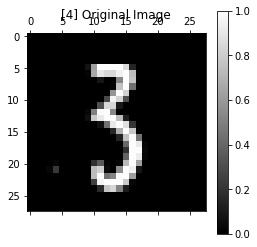

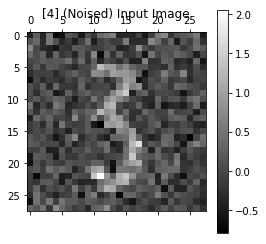

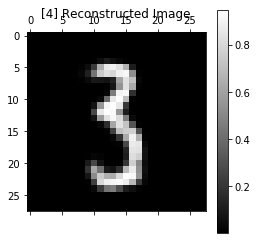

In [49]:
#index = random.choice(range(10000))
index=7692
test = test_dataset[index][0]

plt.matshow(np.reshape(test.numpy(), (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("[" + str(epoch) + "] Original Image\n")
plt.colorbar()
plt.show()

noised = Variable(test) + 0.3*Variable(torch.randn(test.size()))

plt.matshow(np.reshape(noised.data.numpy(), (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("[" + str(epoch) + "] (Noised) Input Image\n")
plt.colorbar()
plt.show()

recon = model(noised.view(-1,28*28),False)

plt.matshow(np.reshape(recon.data.numpy(), (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("[" + str(epoch) + "] Reconstructed Image\n")
plt.colorbar()
plt.show()